In [10]:
"""
Explicación general (cómo funciona este notebook)

Resumen rápido:
1) Se generan muchos colores candidatos en HSL (tono aleatorio, saturación alta, luminosidad media).
2) Se convierten a RGB y a Lab; en Lab la distancia (ΔE) se correlaciona mejor con diferencia visual.
3) Se seleccionan n colores con muestreo "maximin": cada nuevo color es el que está más lejos de los ya elegidos,
   evitando colores parecidos y maximizando la separación perceptual entre todos.
4) Se comprueba el contraste de cada color contra un fondo (bg_hex). Si es bajo, se ajusta la L (luminosidad)
   para mejorar legibilidad sin distorsionar demasiado el color.
5) Para cada color se guarda: hex, rgb (0-255), lab, el código Aegis para ASS/SSA, el contraste y la distancia mínima
   a los demás (min ΔE).
6) La función show_palette dibuja bloques de color, calcula localmente si el texto debe ser negro o blanco, y muestra
   debajo el HEX, la info (ΔE y contraste) y el código Aegis.

Entradas clave:
- n: cuántos colores distintos quieres.
- seed: semilla para resultados reproducibles.
- candidates: cuántos candidatos se generan antes de seleccionar los mejores.
- bg_hex: color de fondo frente al que se mide el contraste.
- wcag_threshold: umbral mínimo de contraste deseado.
- fixed_hex: lista opcional de colores forzados ("semillas") que se incluyen sí o sí.
- configurations: NUEVO parámetro opcional. Si se pasa, se ignora n y se calcula número de colores como el número de
  sílabas únicas presentes (tokens separados por '-'). Se preserva el orden de primera aparición.

Salidas:
- Una lista (paleta) de n diccionarios con la info de cada color, lista para usarse y visualizarse.
- Con assign_syllable_colors se genera un mapeo token -> color considerando heurísticas de armonía.
"""

from __future__ import annotations
from typing import TypedDict

# Definición de tipos
RGB255 = tuple[int, int, int]
Lab = tuple[float, float, float]

class PaletteColor(TypedDict):
    """Representa un color dentro de la paleta.

    :var hex: Representación hexadecimal (#rrggbb).
    :var rgb: Tripleta RGB en entero (0-255).
    :var lab: Tripleta Lab (L*, a*, b*) redondeada.
    :var aegis: Código para ASS/SSA en formato ``{\\c&HBBGGRR&}``.
    :var contrast_vs_bg: Ratio de contraste frente al fondo especificado.
    :var min_delta_e: Distancia mínima ΔE respecto a otra entrada de la paleta (None si solo hay un color).
    """
    hex: str
    rgb: RGB255
    lab: Lab
    aegis: str
    contrast_vs_bg: float
    min_delta_e: float | None

import random, math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
from math import sqrt, pow, atan2, degrees
from collections import defaultdict, deque

plt.style.use('default')
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.edgecolor': 'black'
})

# ------------------- utilidades de color -------------------
def clamp01(x: float) -> float:
    """Limita un valor al rango [0,1].

    :param x: Valor de entrada.
    :returns: ``x`` recortado al intervalo ``[0.0, 1.0]``.
    """
    return max(0.0, min(1.0, x))

def rgb_frac_to_hex(rgb: tuple[float, float, float]) -> str:
    """Convierte una tripleta RGB fraccional (0-1) a cadena hexadecimal.

    :param rgb: Tripleta ``(r,g,b)`` en fracciones.
    :returns: Cadena ``#rrggbb``.
    """
    return '#{:02x}{:02x}{:02x}'.format(int(clamp01(rgb[0])*255+0.5), int(clamp01(rgb[1])*255+0.5), int(clamp01(rgb[2])*255+0.5))

def hex_to_rgb_frac(h: str) -> tuple[float, float, float]:
    """Convierte una cadena ``#rrggbb`` a tripleta fraccional.

    :param h: Color en formato hexadecimal (con o sin ``#``).
    :returns: Tripleta fraccional ``(r,g,b)``.
    """
    h = h.lstrip('#'); return (int(h[0:2],16)/255.0, int(h[2:4],16)/255.0, int(h[4:6],16)/255.0)

def srgb_to_linear(c: float) -> float:
    """Convierte componente sRGB a espacio lineal.

    :param c: Componente sRGB (0-1).
    :returns: Componente lineal.
    """
    return c/12.92 if c <= 0.04045 else pow((c+0.055)/1.055, 2.4)

def linear_to_srgb(c: float) -> float:
    """Convierte componente lineal a sRGB.

    :param c: Valor lineal.
    :returns: Valor en espacio sRGB.
    """
    return 12.92*c if c <= 0.0031308 else 1.055*pow(c, 1/2.4)-0.055

def rgb_to_xyz(rgb: tuple[float, float, float]) -> tuple[float, float, float]:
    """Convierte RGB fraccional a espacio CIE XYZ (D65).

    :param rgb: Tripleta fraccional.
    :returns: Tripleta XYZ.
    """
    r,g,b = rgb; r_l = srgb_to_linear(r); g_l = srgb_to_linear(g); b_l = srgb_to_linear(b)
    x = r_l*0.4124564 + g_l*0.3575761 + b_l*0.1804375; y = r_l*0.2126729 + g_l*0.7151522 + b_l*0.0721750; z = r_l*0.0193339 + g_l*0.1191920 + b_l*0.9503041
    return (x,y,z)

def xyz_to_rgb(xyz: tuple[float, float, float]) -> tuple[float, float, float]:
    """Convierte coordenadas XYZ a RGB fraccional.

    :param xyz: Tripleta XYZ.
    :returns: Tripleta RGB fraccional.
    """
    x,y,z = xyz; r_l = x*3.2404542 + y*-1.5371385 + z*-0.4985314; g_l = x*-0.9692660 + y*1.8760108 + z*0.0415560; b_l = x*0.0556434 + y*-0.2040259 + z*1.0572252
    return (linear_to_srgb(r_l), linear_to_srgb(g_l), linear_to_srgb(b_l))

def xyz_to_lab(xyz: tuple[float, float, float]) -> Lab:
    """Convierte XYZ a CIE Lab.

    :param xyz: Tripleta XYZ.
    :returns: Tripleta Lab.
    """
    xr, yr, zr = 0.95047, 1.00000, 1.08883; x,y,z = xyz
    def f(t: float) -> float: return pow(t,1/3) if t > 0.008856 else 7.787*t + 16.0/116.0
    fx = f(x/xr); fy = f(y/yr); fz = f(z/zr); L = 116.0*fy - 16.0; a = 500.0*(fx - fy); b = 200.0*(fy - fz); return (L,a,b)

def lab_to_xyz(lab: Lab) -> tuple[float, float, float]:
    """Convierte Lab a XYZ.

    :param lab: Tripleta Lab.
    :returns: Tripleta XYZ.
    """
    L,a,b = lab; fy = (L+16.0)/116.0; fx = a/500.0 + fy; fz = fy - b/200.0
    def f_inv(t: float) -> float: return t**3 if t**3 > 0.008856 else (t - 16.0/116.0)/7.787
    xr, yr, zr = 0.95047, 1.00000, 1.08883; x = xr*f_inv(fx); y = yr*f_inv(fy); z = zr*f_inv(fz); return (x,y,z)

def rgb_to_lab(rgb: tuple[float, float, float]) -> Lab:
    """Convierte RGB fraccional directamente a Lab.

    :param rgb: Tripleta fraccional.
    :returns: Tripleta Lab.
    """
    return xyz_to_lab(rgb_to_xyz(rgb))

def lab_to_rgb(lab: Lab) -> tuple[float, float, float]:
    """Convierte Lab a RGB fraccional.

    :param lab: Tripleta Lab.
    :returns: Tripleta fraccional.
    """
    return xyz_to_rgb(lab_to_xyz(lab))

def hsl_to_rgb(h_deg: float, s: float, l: float) -> tuple[float, float, float]:
    """Convierte valores HSL a RGB fraccional.

    :param h_deg: Tono en grados [0,360).
    :param s: Saturación (0-1).
    :param l: Luminosidad (0-1).
    :returns: Tripleta RGB fraccional.
    """
    h = (h_deg % 360)/360.0
    if s == 0: return (l,l,l)
    def hue2rgb(p: float, q: float, t: float) -> float:
        if t < 0: t += 1
        if t > 1: t -= 1
        if t < 1/6: return p + (q-p)*6*t
        if t < 1/2: return q
        if t < 2/3: return p + (q-p)*(2/3 - t)*6
        return p
    q = l*(1+s) if l < 0.5 else l + s - l*s; p = 2*l - q
    return (hue2rgb(p,q,h+1/3), hue2rgb(p,q,h), hue2rgb(p,q,h-1/3))

def relative_luminance(rgb: tuple[float, float, float]) -> float:
    """Calcula la luminancia relativa (WCAG 2.1) de un color.

    :param rgb: Tripleta fraccional.
    :returns: Luminancia relativa.
    """
    def f(c: float) -> float: c = clamp01(c); return c/12.92 if c <= 0.03928 else ((c+0.055)/1.055)**2.4
    r,g,b = rgb; return 0.2126*f(r) + 0.7152*f(g) + 0.0722*f(b)

def contrast_ratio(rgb1: tuple[float, float, float], rgb2: tuple[float, float, float]) -> float:
    """Calcula el ratio de contraste entre dos colores.

    :param rgb1: Primer color (fraccional).
    :param rgb2: Segundo color (fraccional).
    :returns: Ratio ``(L_high+0.05)/(L_low+0.05)``.
    """
    L1 = relative_luminance(rgb1); L2 = relative_luminance(rgb2); L_high, L_low = max(L1,L2), min(L1,L2); return (L_high + 0.05)/(L_low + 0.05)

def hex_to_aegis_bgr(hexstr: str) -> str:
    """Convierte ``#rrggbb`` al orden BGR requerido por códigos Aegis.

    :param hexstr: Cadena hexadecimal.
    :returns: Cadena ``BBGGRR``.
    """
    h = hexstr.lstrip('#'); h = h if len(h)==6 else (h+"000000")[:6]; rr,gg,bb = h[0:2].upper(), h[2:4].upper(), h[4:6].upper(); return bb+gg+rr

# ---- NUEVO: utilidades de LCh y familias de color ----
def lab_to_lch(lab: Lab) -> tuple[float, float, float]:
    """Convierte Lab a coordenadas LCh (Lightness, Chroma, Hue).

    :param lab: Tripleta Lab.
    :returns: Tripleta ``(L, C, h)`` donde ``h`` está en grados [0,360).
    """
    L,a,b = lab
    C = math.sqrt(a*a + b*b)
    h = degrees(atan2(b, a))
    if h < 0: h += 360.0
    return (L, C, h)

def hue_distance(h1: float, h2: float) -> float:
    """Distancia angular mínima entre dos tonos en grados.

    :param h1: Primer tono.
    :param h2: Segundo tono.
    :returns: Distancia circular en grados (0-180).
    """
    d = abs(h1 - h2) % 360.0
    return d if d <= 180.0 else 360.0 - d

def hue_family(h: float) -> str:
    """Clasifica un tono en una familia gruesa de color.

    Familias: ``red``, ``orange``, ``yellow``, ``green``, ``cyan``, ``blue``, ``purple``.

    :param h: Tono en grados.
    :returns: Nombre de familia.
    """
    if h < 30 or h >= 330: return 'red'
    if h < 60: return 'orange'
    if h < 90: return 'yellow'
    if h < 150: return 'green'
    if h < 210: return 'cyan'
    if h < 270: return 'blue'
    return 'purple'

# ------------------- parseo de configuraciones -------------------
def parse_configurations(configurations: list[str]) -> list[str]:
    """Extrae tokens únicos preservando orden de primera aparición.

    :param configurations: Lista de cadenas con posibles separadores ``-``.
    :returns: Lista de tokens únicos en orden.
    :raises ValueError: Si la lista está vacía.
    """
    seen: set[str] = set(); ordered: list[str] = []
    for conf in configurations:
        parts = conf.split('-') if '-' in conf else [conf]
        for p in parts:
            p = p.strip()
            if p and p not in seen:
                seen.add(p); ordered.append(p)
    return ordered

# ------------------- generate_palette -------------------
def generate_palette(
    n: int | None = None,
    seed: int | None = None,
    candidates: int = 800,
    bg_hex: str = '#ffffff',
    wcag_threshold: float = 4.5,
    fixed_hex: list[str] | None = None,
    adjust_fixed: bool = True,
    configurations: list[str] | None = None,
) -> list[PaletteColor]:
    """Genera una paleta de colores diversa con buen contraste.

    Si se proporciona ``configurations`` se ignora ``n`` y el tamaño de la paleta se deriva de los tokens únicos.
    Se usa un muestreo maximin en espacio Lab para maximizar separación perceptual, ajustando luminancia para alcanzar
    un contraste mínimo contra ``bg_hex``.

    :param n: Número de colores deseados (si no se dan configuraciones).
    :param seed: Semilla para reproducibilidad.
    :param candidates: Número de candidatos HSL aleatorios antes de seleccionar.
    :param bg_hex: Color de fondo para cálculo de contraste.
    :param wcag_threshold: Umbral mínimo de contraste (WCAG aproximado).
    :param fixed_hex: Lista de colores ya fijados que se incluirán primero.
    :param adjust_fixed: Si ``True`` permite ajustar L de los colores fijos para mejorar contraste.
    :param configurations: Lista de configuraciones; determina tokens únicos.
    :returns: Lista de estructuras ``PaletteColor``.
    :raises ValueError: Si no se puede determinar ``n``.
    """
    if configurations is not None:
        tokens = parse_configurations(configurations)
        if not tokens: raise ValueError("configurations vacías; no se pueden derivar tokens")
        n = len(tokens)
    if n is None: raise ValueError("Debe proporcionar n o configurations")
    random.seed(seed)
    fixed_hex = fixed_hex or []
    seen: set[str] = set(); fixed_norm: list[str] = []
    for h in fixed_hex:  # Normalización y filtrado de colores fijos
        if not h: continue
        h_norm = '#' + h.lstrip('#').lower()
        if len(h_norm) != 7: continue
        if h_norm not in seen:
            seen.add(h_norm); fixed_norm.append(h_norm)
    m_fixed = min(len(fixed_norm), n); fixed_norm = fixed_norm[:m_fixed]; additional = max(0, n - m_fixed)
    cand_rgb: list[tuple[float, float, float]] = []
    for _ in range(candidates):  # Generación aleatoria HSL controlada
        h = random.random()*360.0; s = random.uniform(0.45,0.95); l = random.uniform(0.28,0.72)
        cand_rgb.append(hsl_to_rgb(h,s,l))
    cand_lab = [rgb_to_lab(c) for c in cand_rgb]
    fixed_rgbs = [hex_to_rgb_frac(h) for h in fixed_norm]; fixed_labs = [rgb_to_lab(rgb) for rgb in fixed_rgbs]
    palette_idx: list[int] = []
    if additional > 0:
        if not fixed_labs:
            first = random.randrange(len(cand_rgb)); palette_idx.append(first)
        while len(palette_idx) < additional:  # Selección maximin iterativa
            best_i = None; best_dist = -1.0
            for i, lab in enumerate(cand_lab):
                if i in palette_idx: continue
                min_to_fixed = min(sqrt((lab[0]-fl[0])**2 + (lab[1]-fl[1])**2 + (lab[2]-fl[2])**2) for fl in fixed_labs) if fixed_labs else float('inf')
                min_to_selected = min(sqrt((lab[0]-cand_lab[j][0])**2 + (lab[1]-cand_lab[j][1])**2 + (lab[2]-cand_lab[j][2])**2) for j in palette_idx) if palette_idx else float('inf')
                mind = min(min_to_fixed, min_to_selected)
                if mind > best_dist: best_dist = mind; best_i = i
            if best_i is None: break
            palette_idx.append(best_i)
    bg_rgb = hex_to_rgb_frac(bg_hex); results: list[PaletteColor] = []
    def build_entry(rgbf: tuple[float,float,float], allow_adjust: bool) -> PaletteColor:
        """Construye la entrada ``PaletteColor`` aplicando ajuste de contraste si procede.

        :param rgbf: Tripleta fraccional inicial.
        :param allow_adjust: Permite modificar L para mejorar contraste.
        :returns: Estructura ``PaletteColor`` poblada.
        """
        lab = rgb_to_lab(rgbf); hexc = rgb_frac_to_hex(rgbf); cr_bg = contrast_ratio(rgbf, bg_rgb)
        if allow_adjust and cr_bg < wcag_threshold:
            bg_lab = rgb_to_lab(bg_rgb)
            direction = -1 if lab[0] < bg_lab[0] else 1
            attempts = 0
            while cr_bg < wcag_threshold and attempts < 10:
                L_new = max(3, min(97, lab[0] + direction * 6.0))
                new_rgb = lab_to_rgb((L_new, lab[1], lab[2]))
                if all(0.0 <= c <= 1.0 for c in new_rgb):
                    new_cr = contrast_ratio(new_rgb, bg_rgb)
                    if new_cr > cr_bg:
                        rgbf = new_rgb; lab = rgb_to_lab(rgbf); hexc = rgb_frac_to_hex(rgbf); cr_bg = new_cr
                    else:
                        direction *= -1
                else:
                    direction *= -1
                attempts += 1
        bgr = hex_to_aegis_bgr(hexc); aegis_code = r"{\c&H" + bgr + r"&}"; r_f,g_f,b_f = rgbf
        rgb255: RGB255 = (int(clamp01(r_f)*255+0.5), int(clamp01(g_f)*255+0.5), int(clamp01(b_f)*255+0.5))
        L_, a_, b_ = lab; lab_round: Lab = (round(L_,2), round(a_,2), round(b_,2))
        return PaletteColor(hex=hexc, rgb=rgb255, lab=lab_round, aegis=aegis_code, contrast_vs_bg=round(cr_bg,2), min_delta_e=None)
    for rgbf in fixed_rgbs: results.append(build_entry(rgbf, allow_adjust=adjust_fixed))
    for i in palette_idx: results.append(build_entry(cand_rgb[i], allow_adjust=True))
    labs = [rgb_to_lab((r['rgb'][0]/255.0, r['rgb'][1]/255.0, r['rgb'][2]/255.0)) for r in results]
    for idx, r in enumerate(results):
        if len(labs) <= 1: r['min_delta_e'] = None
        else:
            m = min(sqrt((labs[idx][0]-labs[j][0])**2 + (labs[idx][1]-labs[j][1])**2 + (labs[idx][2]-labs[j][2])**2) for j in range(len(labs)) if j != idx)
            r['min_delta_e'] = round(m,2)
    return results

# ------------------- adyacencias -------------------
def delta_e(lab1: Lab, lab2: Lab) -> float:
    """Distancia euclídea simplificada ΔE entre dos colores en Lab.

    :param lab1: Primer color Lab.
    :param lab2: Segundo color Lab.
    :returns: Distancia ΔE.
    """
    return sqrt((lab1[0]-lab2[0])**2 + (lab1[1]-lab2[1])**2 + (lab1[2]-lab2[2])**2)

def build_adjacency(configurations: list[str]) -> dict[str, set[str]]:
    """Construye mapa de adyacencias (vecinos directos) entre tokens.

    :param configurations: Lista de configuraciones con tokens separados por ``-``.
    :returns: Diccionario token -> conjunto de vecinos.
    """
    adj: dict[str,set[str]] = defaultdict(set)
    for conf in configurations:
        parts = conf.split('-') if '-' in conf else [conf]
        for i in range(len(parts)-1):
            a = parts[i].strip(); b = parts[i+1].strip();
            if a and b: adj[a].add(b); adj[b].add(a)
    return adj

# ------------------- NUEVO: asignación con familias de color -------------------
def assign_syllable_colors(palette: list[PaletteColor], configurations: list[str]) -> tuple[dict[str,str], list[str]]:
    """Asigna colores a cada token buscando separación de familias y contraste perceptual.

    Heurística:
    - Evita reutilizar misma familia de color en vecinos directos.
    - Penaliza reutilización reciente de familia (ventana global).
    - Mantiene distancias de tono dentro de una ventana objetivo (hue_min/hue_max) y aproxima hue_target.
    - Controla ΔE para evitar colores demasiado similares o excesivamente lejanos.

    :param palette: Paleta base generada por ``generate_palette``.
    :param configurations: Lista de configuraciones para derivar tokens y adyacencias.
    :returns: ``(mapa_token_color, lista_tokens_en_orden)``.
    """
    tokens = parse_configurations(configurations)
    adj = build_adjacency(configurations)

    # Meta de separaciones
    de_min, de_max = 25.0, 75.0
    hue_min, hue_target, hue_max = 40.0, 75.0, 160.0
    recent_window = 3
    recent_penalty = 50.0

    # Pre-cálculo de LCh y familias para la paleta
    pal_lab = [c['lab'] for c in palette]
    pal_lch = [lab_to_lch(l) for l in pal_lab]
    pal_hue = [lc[2] for lc in pal_lch]
    pal_family = [hue_family(h) for h in pal_hue]

    available_indices = list(range(len(palette)))
    token_color: dict[str, str] = {}
    token_lab: dict[str, Lab] = {}
    token_hue: dict[str, float] = {}
    token_family: dict[str, str] = {}
    recent = deque(maxlen=recent_window)

    for tok in tokens:
        neighbors = [n for n in adj.get(tok, []) if n in token_lab]

        # Primera pasada: prohibir misma familia que cualquiera de los vecinos
        neighbor_fams = {token_family[n] for n in neighbors}
        candidate_pool = [idx for idx in available_indices if not neighbor_fams or pal_family[idx] not in neighbor_fams]
        relax = False
        if not candidate_pool:
            # Si no hay opciones, relajamos (pero con fuerte penalización por familia igual)
            candidate_pool = available_indices[:]
            relax = True

        best_idx = None
        best_score = float('inf')
        for idx in candidate_pool:
            score = 0.0
            # Penalización por familia igual a vecinos (si entramos en modo relax)
            if relax and neighbors:
                samefam = sum(1 for n in neighbors if pal_family[idx] == token_family[n])
                score += samefam * 1000.0  # muy alto para que sea último recurso

            # Penalización por repetir familia reciente (global)
            if pal_family[idx] in recent:
                score += recent_penalty

            # Evaluación frente a vecinos: hue y ΔE
            if neighbors:
                ds_hue = []
                ds_de = []
                for n in neighbors:
                    dH = hue_distance(pal_hue[idx], token_hue[n])
                    ds_hue.append(dH)
                    dE = delta_e(pal_lab[idx], token_lab[n])
                    ds_de.append(dE)
                    # Penalizaciones por hue fuera de zona objetivo
                    if dH < hue_min:
                        score += (hue_min - dH) * 3.0
                    elif dH > hue_max:
                        score += (dH - hue_max) * 0.5
                    # Penalizaciones por ΔE
                    if dE < de_min:
                        score += (de_min - dE) * 2.5
                    elif dE > de_max:
                        score += (dE - de_max) * 0.5
                # Acercar la media del hue a la diana
                avg_h = sum(ds_hue)/len(ds_hue)
                score += abs(avg_h - hue_target) * 0.7
                # L preferida media (evitar extremos), toque suave
                L = pal_lch[idx][0]
                score += abs(L - 55.0) * 0.05
            else:
                # Primeros tokens: preferir L moderada y penalizar familias ya recientes
                L = pal_lch[idx][0]
                score += abs(L - 55.0) * 0.1

            if score < best_score:
                best_score = score
                best_idx = idx

        if best_idx is None:
            best_idx = available_indices[0]

        chosen = palette[best_idx]
        token_color[tok] = chosen['hex']
        token_lab[tok] = pal_lab[best_idx]
        token_hue[tok] = pal_hue[best_idx]
        token_family[tok] = pal_family[best_idx]

        available_indices.remove(best_idx)
        recent.append(pal_family[best_idx])

        # Si nos quedamos sin colores (raro cuando n==len(paleta)), reciclamos como último recurso
        if not available_indices:
            available_indices = list(range(len(palette)))

    return token_color, tokens

# ------------------- Visualización y exportación -------------------

def ordered_palette_for_tokens(token_color_map: dict[str,str], palette: list[PaletteColor], tokens_in_order: list[str]) -> list[PaletteColor]:
    """Obtiene entradas de paleta ordenadas según lista de tokens.

    :param token_color_map: Mapeo token -> hex.
    :param palette: Paleta completa.
    :param tokens_in_order: Orden deseado de tokens.
    :returns: Lista filtrada y ordenada de ``PaletteColor``.
    """
    hex_to_entry = {c['hex']: c for c in palette}; ordered: list[PaletteColor] = []; seen_hex: set[str] = set()
    for t in tokens_in_order:
        hx = token_color_map.get(t)
        if hx and hx in hex_to_entry and hx not in seen_hex:
            ordered.append(hex_to_entry[hx]); seen_hex.add(hx)
    return ordered

def print_js_structure(var_name: str, token_color_map: dict[str,str], configurations: list[str]) -> None:
    """Imprime estructura estilo objeto JS con colores y códigos Aegis.

    :param var_name: Nombre de variable JS.
    :param token_color_map: Mapeo token -> hex.
    :param configurations: Lista original de configuraciones.
    :returns: ``None`` (solo imprime).
    """
    var_name = var_name.strip() or 'PaletteData'; aegis_map = {tok: '{\\c&H' + hex_to_aegis_bgr(color) + '&}' for tok,color in token_color_map.items()}
    print(f"{var_name} = {{")
    print("    \"palette\": {")
    for tok in token_color_map:
        color = token_color_map[tok]; aegis = aegis_map[tok]
        print(f"        \"{tok}\": \"{color}\", // {aegis}")
    print("    },")
    print("    \"configurations\": [" + ", ".join(f"\"{c}\"" for c in configurations) + "]")
    print("}")

# NUEVO: impresión de diccionario Python con códigos Aegis (formato compacto una sola línea)

def print_python_dict_aegis(var_name: str, token_color_map: dict[str, str], tokens_in_order: list[str] | None = None) -> None:
    """Imprime un diccionario Python token -> código Aegis en una sola línea.

    :param var_name: Nombre de la variable a declarar.
    :param token_color_map: Mapeo token -> hex.
    :param tokens_in_order: Orden opcional de tokens para respetar aparición.
    :returns: ``None``.
    """
    name = (var_name or 'palette_aegis').strip()
    order = tokens_in_order or list(token_color_map.keys())
    pairs = []
    for tok in order:
        if tok not in token_color_map:
            continue
        aegis = '{\\c&H' + hex_to_aegis_bgr(token_color_map[tok]) + '&}'
        pairs.append(f"'{tok}': '{aegis}'")
    line = ", ".join(pairs)
    print(f"{name} = {{{line}}}")

def show_palette(palette: list[PaletteColor], block_w: float = 1.0, block_h: float = 1.0, spacing: float = 0.4, cols: int | None = None, hex_fontsize: int = 12, info_fontsize: int = 9) -> None:
    """Visualiza la paleta como bloques de color con info adicional.

    :param palette: Lista de colores.
    :param block_w: Anchura de cada bloque.
    :param block_h: Altura de cada bloque.
    :param spacing: Espaciado horizontal entre bloques.
    :param cols: Número de columnas (auto si ``None``).
    :param hex_fontsize: Tamaño de fuente para el código hex.
    :param info_fontsize: Tamaño de fuente para info ΔE y contraste.
    :returns: ``None``.
    """
    n = len(palette); cols = min(n,12) if cols is None else max(1,int(cols)); rows = math.ceil(n/cols)
    margin_y = 0.9; margin_x = 0.6
    fig_w = cols*(block_w+spacing)+margin_x*2; fig_h = rows*(block_h+margin_y)+margin_y
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    try: fig.patch.set_facecolor('white'); ax.set_facecolor('white')
    except Exception: pass
    ax.set_xlim(0, cols*(block_w+spacing)+margin_x*2); ax.set_ylim(0, rows*(block_h+margin_y)+margin_y); ax.axis('off')
    for idx, c in enumerate(palette):
        row = idx // cols; col = idx % cols; x = margin_x + col*(block_w+spacing); y = margin_y + (rows-1-row)*(block_h+margin_y*0.95)
        rect = Rectangle((x,y), block_w, block_h, facecolor=c['hex'], edgecolor='none'); ax.add_patch(rect)
        rgb_frac = (c['rgb'][0]/255.0, c['rgb'][1]/255.0, c['rgb'][2]/255.0); black=(0.0,0.0,0.0); white=(1.0,1.0,1.0)
        cr_black = contrast_ratio(rgb_frac, black); cr_white = contrast_ratio(rgb_frac, white); label_color = '#000000' if cr_black >= cr_white else '#ffffff'
        ax.text(x+block_w/2, y-0.15, c['hex'], ha='center', va='top', fontsize=hex_fontsize, color=label_color, weight='700', clip_on=False)
        info = f"ΔE≈{c['min_delta_e']}  cr:{c['contrast_vs_bg']}"; ax.text(x+block_w/2, y-0.45, info, ha='center', va='top', fontsize=info_fontsize, color=label_color, clip_on=False)
        ax.text(x+block_w/2, y-0.75, c['aegis'], ha='center', va='top', fontsize=max(8, info_fontsize-1), color=label_color, clip_on=False)
    plt.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.04); plt.show()

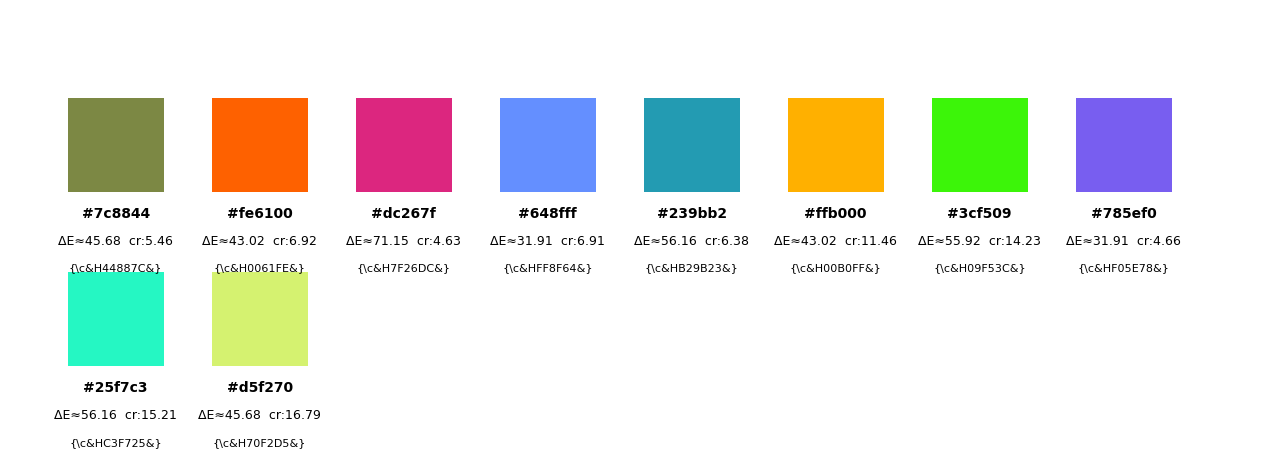


--- JS Structure ---
SweetPain = {
    "palette": {
        "U1": "#7c8844", // {\c&H44887C&}
        "A1": "#fe6100", // {\c&H0061FE&}
        "O1": "#dc267f", // {\c&H7F26DC&}
        "E1": "#648fff", // {\c&HFF8F64&}
        "I1": "#239bb2", // {\c&HB29B23&}
        "OE": "#ffb000", // {\c&H00B0FF&}
        "AIE": "#3cf509", // {\c&H09F53C&}
        "UA": "#785ef0", // {\c&HF05E78&}
        "AIA": "#25f7c3", // {\c&HC3F725&}
        "EIO": "#d5f270", // {\c&H70F2D5&}
    },
    "configurations": ["U1-A1-O1-E1-I1", "OE", "AIE", "UA", "AIA", "EIO"]
}

--- Python dict (Aegis) ---
palette_aegis = {'U1': '{\c&H44887C&}', 'A1': '{\c&H0061FE&}', 'O1': '{\c&H7F26DC&}', 'E1': '{\c&HFF8F64&}', 'I1': '{\c&HB29B23&}', 'OE': '{\c&H00B0FF&}', 'AIE': '{\c&H09F53C&}', 'UA': '{\c&HF05E78&}', 'AIA': '{\c&HC3F725&}', 'EIO': '{\c&H70F2D5&}'}


In [ ]:
# ------------------- EJEMPLO DE USO (con configurations) -------------------
# Lista de configuraciones (orden de primera aparición)
titulo = "CompareFlow_1"
configurations = ["U1-AI", "O1-E1-A1", "ENCIA", "IE-E2-E3-A2", "E1-E4-U1-O1"]
# Colores fijos de ejemplo (opcional)
fixed = ['#648FFF', '#785EF0', '#DC267F', '#FE6100',
         '#FFB000']

# Generar paleta automáticamente a partir del número de tokens únicos en configurations
palette_raw = generate_palette(
    n=None,
    configurations=configurations,
    seed=201721022,
    candidates=2048,
    bg_hex="#000000",
    wcag_threshold=4.5,
    #fixed_hex=fixed,
    adjust_fixed=True,
)

# Asignar colores armoniosos a las sílabas
syllable_color_map, tokens_order = assign_syllable_colors(palette_raw, configurations)

# Construir un dataframe para inspección
palette_ordered_entries = ordered_palette_for_tokens(syllable_color_map, palette_raw, tokens_order)

df = pd.DataFrame([
    {
        'token': tok,
        'hex': syllable_color_map[tok],
        'aegis': '{\\c&H' + hex_to_aegis_bgr(syllable_color_map[tok]) + '&}',
    } for tok in tokens_order
])
#print("Tokens únicos en orden de aparición:")
#print(tokens_order)
#print("\nMapa token -> color:")
#print(df)

# Mostrar figura con los colores ordenados por aparición
show_palette(palette_ordered_entries, block_w=1.0, block_h=1.0, spacing=0.5, cols=8, hex_fontsize=10, info_fontsize=9)

# Impresión estilo JS para copiar (nombre de variable opcional)
print("\n--- JS Structure ---")
print_js_structure(titulo, syllable_color_map, configurations)

# NUEVO: impresión de diccionario Python con Aegis
print("\n--- Python dict (Aegis) ---")
print_python_dict_aegis("palette_aegis", syllable_color_map, tokens_order)